In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
from utils import *
from scipy import stats
import statsmodels.api as sm

In [2]:
import pandas as pd

In [54]:
from utils import *
client=get_cluster(25)

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45379 instead
  warnings.warn(


In [174]:
yys=[[1960,1989],[1989,2018],[2073,2099]]
mnames={'cesm1': 'CESM1', 'cesm2': 'CESM2', 'mpige': 'MPI-GE', 'mpi12': 'MPI-1.2'}

In [5]:
def getxy(mdl,yy):
    cf=24*60*60*365
    if 'mpi' in mdl:
        la=xr.open_dataset('mpi_mask_grnlnd_antarc.nc').landarea
    else:
        la=xr.open_dataset('mask_grnlnd_antarc.nc').landarea
    latrop=la.where(abs(la.lat)<24)
    f='../data/globann/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)

    ix=get_ix(ds,yy[0],yy[1])
    midyear=int(np.floor(np.mean(yy)))
    x=1e-9*latrop.sum()*detrend_dim(ds.SW_TROP.isel(year=ix),'year')
    y=1e-9*la.sum()*cf*detrend_dim(ds.NBP.isel(year=ix),'year')

    return x,y

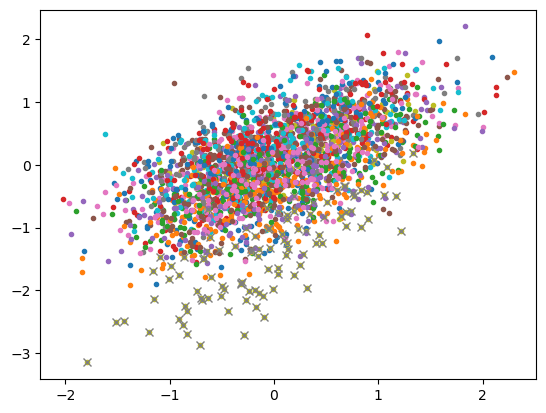

In [10]:
plt.plot(x,y,'.');
plt.plot(x.sel(year=2010),y.sel(year=2010),'x');

In [117]:
import joblib
from joblib import Parallel, delayed

In [68]:


nens=len(ees)

In [128]:
def test_incr(xs,ys,nens,i):
    s=np.arange(len(xs[0].ens))
    np.random.shuffle(s)

    if nens==1:
        ees=[i]
    else:
        ees=s[:nens]

    m=[]
    for xx,yy in zip(xs,ys):
        r=xr.DataArray(np.random.randint(27*nens,size=[1000,27*nens]),dims=['bs','ey'])
        xb=xx.isel(ens=ees).stack({'ey':['ens','year']}).isel(ey=r)
        yb=yy.isel(ens=ees).stack({'ey':['ens','year']}).isel(ey=r)
        m.append([stats.linregress(x,y)[0] for x,y in zip(xb,yb)])
    incr=np.array(m[1])-np.array(m[0])>0

    

    
    return incr.sum()
    

In [178]:
mdls=['cesm1','cesm2','mpige','mpi12']

sigs={mdl:{} for mdl in mdls}
for mdl in mdls:
    print(mdl)
    x1,y1=getxy(mdl,yys[0])
    x2,y2=getxy(mdl,yys[1])
    xs=[x1,x2]
    ys=[y1,y2]
    for nx in [1,10,25]:
        if nx==1:
            nens=len(x1.ens)
        else:
            nens=100
        with joblib.parallel_config(backend="dask"):
            results = Parallel()(delayed(test_incr)(xs,ys,nx,i) for i in range(nens))
        f=np.array(results)
        sig=[(f<=50).sum(),
             ((f>50)&(f<950)).sum(),
             (f>=950).sum()]
        sigs[mdl][nx]=np.array(sig)

cesm1
cesm2
mpige
mpi12


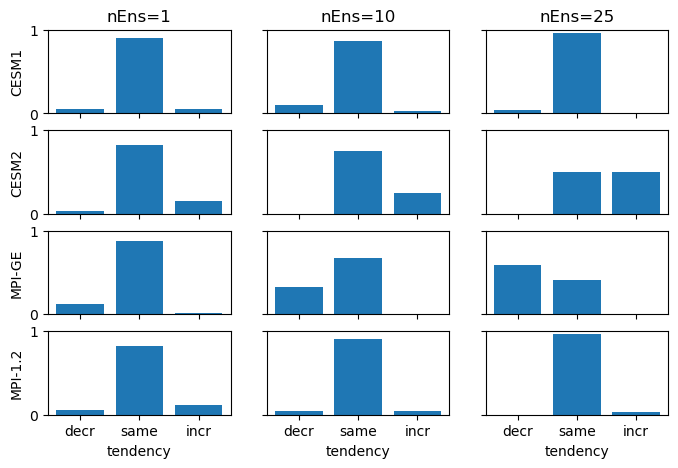

In [181]:
plt.figure(figsize=[8,5])
i=0
for m in mdls:
    for nx in [1,10,25]:
        i+=1
        plt.subplot(4,3,i)
        plt.bar(range(3),sigs[m][nx]/sigs[m][nx].sum())
        plt.ylim([0,1])
        if i<10:
            plt.xticks(range(3),[])
        else:
            plt.xticks(range(3),['decr','same','incr'])
            plt.xlabel('tendency')
        if i%3==1:
            plt.yticks([0,1])
            plt.ylabel(mnames[m])
        else:
            plt.yticks([0,1],[])
        if i<4:
            plt.title('nEns='+str(nx))
plt.savefig('../figs/supp/slope_change_1976_2003.png',dpi=300,bbox_inches='tight')

### full ensemble significance testing
 - used in FIG1

In [252]:
ysets=[]
mids=[]
for aa in yys:
    amid=int(np.floor(np.mean(aa)))
    for bb in yys:
        bmid=int(np.floor(np.mean(bb)))
        if aa!=bb:
            ysets.append((aa,bb))
    mids.append(amid)

In [255]:
mout={mdl:{mid:{} for mid in mids} for mdl in mdls}
for mdl in mdls:
    print(mdl)
    for yset in ysets:
        xs=[]
        ys=[]
        ymid=[]
        for yy in yset:
            x,y=getxy(mdl,yy)
            xs.append(x)
            ys.append(y)
            ymid.append(int(np.floor(np.mean(yy))))
        nens=len(x.ens)
        ms=[]
        for x,y in zip(xs,ys):
            r=xr.DataArray(np.random.randint(27*nens,size=[1000,27*nens]),dims=['bs','ey'])
            xb=x.stack({'ey':['ens','year']}).isel(ey=r)
            yb=y.stack({'ey':['ens','year']}).isel(ey=r)
            m=[stats.linregress(x,y)[0] for x,y in zip(xb,yb)]
            ms.append(m)

        mout[mdl][ymid[0]][ymid[1]]=ms

cesm1
cesm2
mpige
mpi12


In [274]:
with open('sigs.txt','w') as f:
    for mdl in mout:
        for y1 in mids:
            ss=''
            for y2 in mout[mdl][y1]:
                ms=np.array(mout[mdl][y1][y2])
                incr=((ms[1]-ms[0])>0).sum()
                if incr>=950:
                    s='<'
                elif incr<=50:
                    s='>'
                else:
                    s='='
                ss+=s
            w='{},{},{}\n'.format(mdl,y1,ss)
            f.write(w)

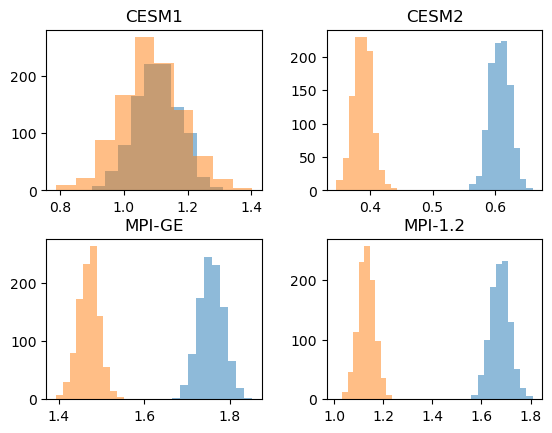

In [231]:
yy='1989v2073'
for i,m in enumerate(mdls):
    plt.subplot(221+i)
    plt.hist(mout[m][yy][0],alpha=0.5)
    plt.hist(mout[m][yy][1],alpha=0.5)
    plt.title(mnames[m])
    plt.subplots_adjust(wspace=0.3,hspace=0.3)

In [216]:
incr=(np.array(ms[1])-np.array(ms[0]))>0
incr.sum()

249

In [90]:
frac=[]
s=np.arange(100)
nens=5
for i in range(100):
    np.random.shuffle(s)
    ees=s[:nens]
    m=[]
    for xx,yy in zip([x1,x2],[y1,y2]):
        r=xr.DataArray(np.random.randint(27*nens,size=[1000,27*nens]),dims=['bs','ey'])
        xb=xx.isel(ens=ees).stack({'ey':['ens','year']}).isel(ey=r)
        yb=yy.isel(ens=ees).stack({'ey':['ens','year']}).isel(ey=r)
        m.append([stats.linregress(x,y)[0] for x,y in zip(xb,yb)])
    incr=np.array(m[1])-np.array(m[0])>0
    frac.append(incr.sum())

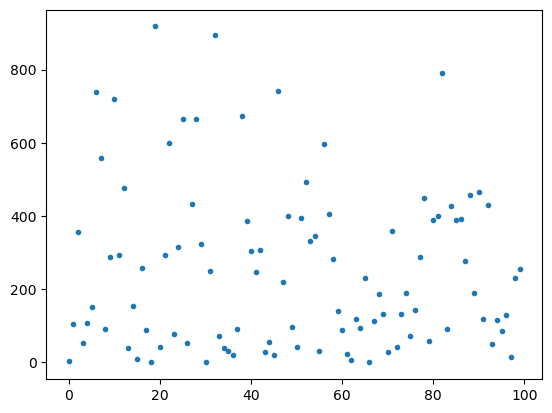

In [91]:
plt.plot(frac,'.')

In [100]:
f=np.array(frac)


In [ ]:
import joblib
from joblib import Parallel, delayed

In [89]:
ix=np.array(m[1])-np.array(m[0])
f=(ix>0).sum()
f


0

In [2]:
f='../data/globann/cesm2.globann.nc'
ds=xr.open_dataset(f)

In [10]:
la=xr.open_dataset('mask_grnlnd_antarc.nc').landarea
latrop=la.where(abs(la.lat)<24)

In [11]:
ixyr=get_ix(ds,1989,2018)
cf=24*60*60*365
x=1e-9*latrop.sum()*ds.SW_TROP.isel(year=ixyr)
y=1e-9*la.sum()*cf*ds.NBP.isel(year=ixyr)

In [103]:
mdls=['cesm1','cesm2','mpige','mpi12']
yrs=['2003','2086']
tests=['wilc','mine']
gle={}
nens=[1,10,25]
for yr in yrs:
    gle[yr]={}
    for ee in nens:
        gle[yr][ee]={}
        for t in tests:
            x=[]
            for i,mdl in enumerate(mdls):
                f='../data/bootstrap/'+mdl+'_1974_'+yr+'_'+t+'.csv'
                df=pd.read_csv(f,index_col=0)
                x.append([df[str(i)][ee] for i in [1,0,-1]])
            gle[yr][ee][t]=np.array(x)

In [72]:
yys={'2003':'1989-2018',
     '2086':'2073-2099'}

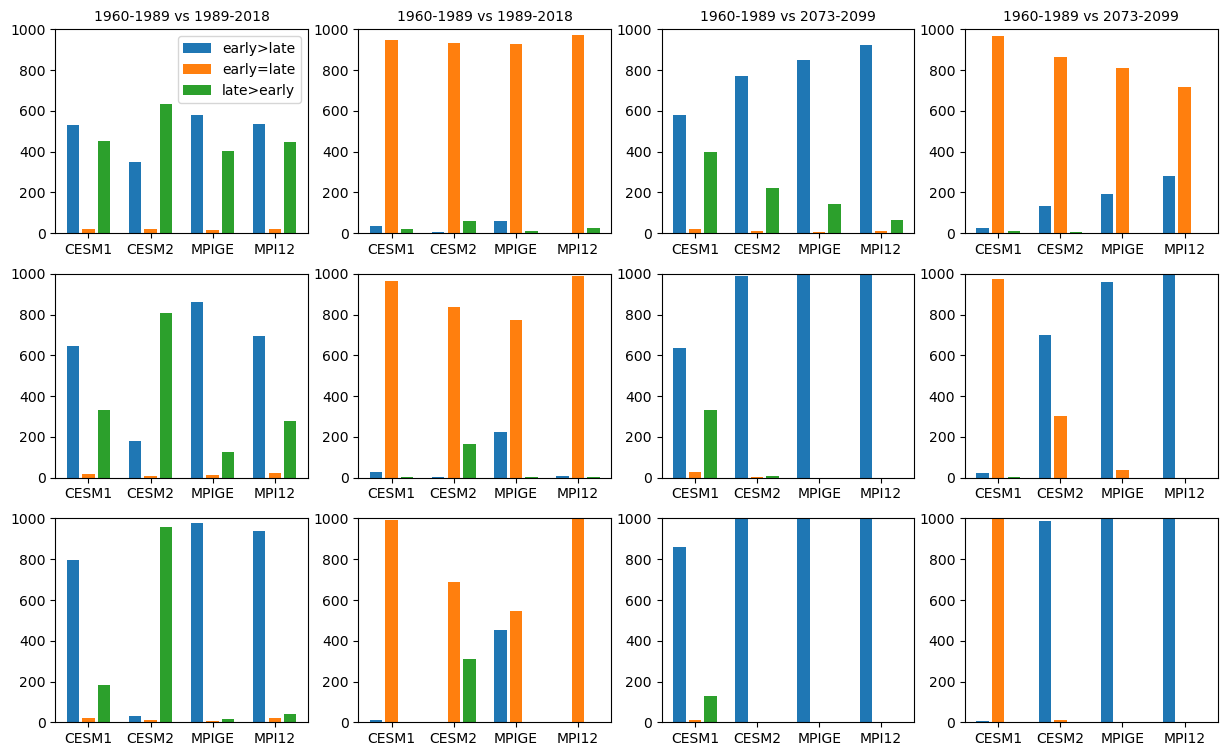

In [104]:
plt.figure(figsize=[15,9])
j=0
for ee in nens:
    for yr in yrs:
        for test in tests:
            j+=1
            plt.subplot(3,4,j)
            for i in range(3):
                plt.bar(np.arange(4)+0.25*i,gle[yr][ee][test][:,i],width=0.2)
            plt.xticks(0.25+np.arange(4),[m.upper() for m in mdls]);
            if j<5:
                plt.title('1960-1989 vs '+yys[yr],fontsize=10)
        
            if j==1:
                plt.legend(['early>late','early=late','late>early'])
            plt.ylim([0,1000])

In [105]:
gle

{'2003': {1: {'wilc': array([[528,  19, 453],
          [349,  18, 633],
          [581,  17, 402],
          [536,  19, 445]]),
   'mine': array([[ 33, 945,  22],
          [  7, 934,  59],
          [ 59, 929,  12],
          [  0, 974,  26]])},
  10: {'wilc': array([[648,  19, 333],
          [182,  10, 808],
          [863,  13, 124],
          [697,  23, 280]]),
   'mine': array([[ 30, 967,   3],
          [  2, 835, 163],
          [225, 774,   1],
          [ 10, 989,   1]])},
  25: {'wilc': array([[795,  21, 184],
          [ 32,  12, 956],
          [980,   4,  16],
          [936,  21,  43]]),
   'mine': array([[  10,  990,    0],
          [   0,  690,  310],
          [ 454,  546,    0],
          [   0, 1000,    0]])}},
 '2086': {1: {'wilc': array([[581,  22, 397],
          [769,  11, 220],
          [849,   6, 145],
          [922,  12,  66]]),
   'mine': array([[ 26, 965,   9],
          [131, 863,   6],
          [190, 810,   0],
          [282, 718,   0]])},
  10: {'w

<BarContainer object of 3 artists>

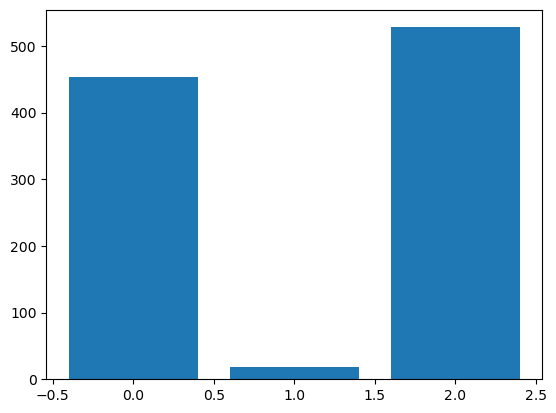

In [29]:
plt.bar(range(3),[df[str(i)][1] for i in [-1,0,1]])

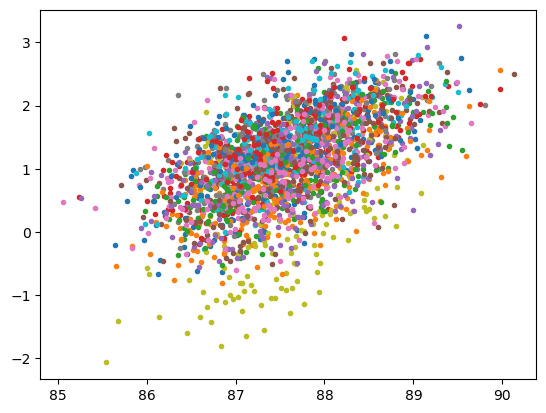

In [12]:
plt.plot(x,y,'.');

In [ ]:
import joblib
from joblib import Parallel, delayed

In [ ]:
import pandas as pd

In [3]:
5+5

10

In [63]:
client=get_cluster()

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33011 instead
  warnings.warn(


In [ ]:
la=xr.open_dataset('mask_grnlnd_antarc.nc').landarea


In [3]:
def getm(mdl,yr):
    f='../data/globann/'+mdl+'.globann.nc'
    ds=xr.open_dataset(f)
    if 'mpi' in mdl:
        la=xr.open_dataset('mpi_mask_grnlnd_antarc.nc').landarea
    else:
        la=xr.open_dataset('mask_grnlnd_antarc.nc').landarea
    latrop=la.where(abs(la.lat)<24)
    
    if yr==2073:
        ixyr=get_ix(ds,yr,yr+26)
    else:
        ixyr=get_ix(ds,yr,yr+29)
    cf=24*60*60*365
    x=1e-9*latrop.sum()*detrend_dim(ds.SW_TROP.isel(year=ixyr),'year')
    y=1e-9*la.sum()*cf*detrend_dim(ds.NBP.isel(year=ixyr),'year')
    
    ixs={j:[subset(ds,j) for i in range(1000)] for j in range(2,26)}
    ixs[1]=ds.ens
    m={j:[stats.linregress(x.sel(ens=ix).values.ravel(),y.sel(ens=ix).values.ravel())[0] for ix in ixs[j]] for j in ixs}
    return m

In [4]:
mdls=['cesm1','cesm2','mpige','mpi12']
m={mdl:{yr:getm(mdl,yr) for yr in [1960,1989,2073]} for mdl in mdls}

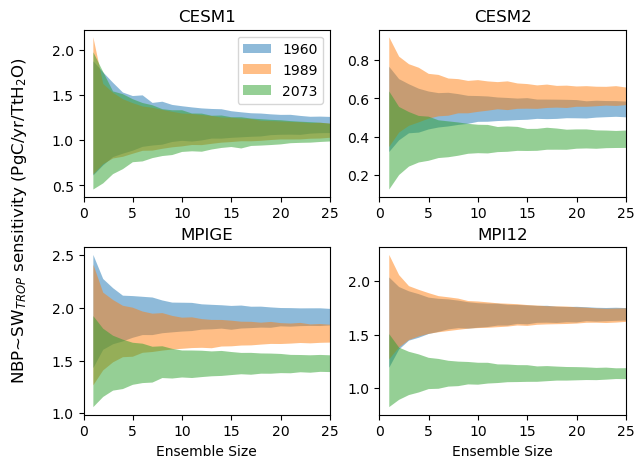

In [15]:
fig=plt.figure(figsize=[7,5])
for i,mdl in enumerate(mdls):
    plt.subplot(221+i)
    for yr in m[mdl]:
        m95=[np.quantile(m[mdl][yr][j],0.95) for j in range(1,26)]
        m05=[np.quantile(m[mdl][yr][j],0.05) for j in range(1,26)]
        plt.fill_between(range(1,26),m05,m95,alpha=0.5,label=yr)
    plt.xlim([0,25])
    
    if i==0:
        plt.legend()
    if i>1:
        plt.xlabel('Ensemble Size')
    plt.title(mdl.upper());
plt.subplots_adjust(hspace=0.3)
fig.supylabel('NBP~SW$_{TROP}$ sensitivity (PgC/yr/TtH$_2$O)')
plt.savefig('../figs/main/fig3.png',dpi=300,bbox_inches='tight')

In [17]:
ds.NBP.sel(ens=ixens).isel(year=ixyr).stack({'ey':['ens','year']})


<xarray.DataArray 'NBP' (ey: 81)>
array([ 3.50542703e-07, -3.58873203e-08,  4.06114288e-07,  7.79145691e-08,
        2.30342518e-07,  4.95930079e-07,  4.68809556e-07,  4.45328009e-07,
        3.55850812e-07,  2.67988665e-07,  1.82029891e-07,  3.87311517e-08,
        5.11599957e-07,  2.16961756e-07,  2.66142323e-07,  3.57882112e-07,
        3.99464322e-07,  3.65320229e-07, -2.52054229e-07,  5.52909098e-07,
        2.92523538e-07,  1.65941064e-07,  3.38975288e-07,  5.50208215e-07,
       -1.16241612e-07,  2.69957939e-07, -2.94902731e-08,  2.61978419e-08,
        3.19244834e-07,  5.02343513e-07,  2.75729192e-07,  3.03670651e-07,
        4.43737021e-07,  2.82240647e-07,  1.18973633e-07,  2.64625695e-07,
        3.96831721e-07,  2.83018813e-07,  4.83566798e-07,  2.34422715e-07,
        2.75211263e-07,  2.22586106e-07,  4.80317787e-07,  3.89259715e-07,
        3.25346211e-07, -4.63021800e-09,  3.94479044e-07,  3.99925541e-07,
        4.75240027e-07,  1.75383330e-08,  3.34550900e-07, -1.30690492e-08,
        4.38262481e-08,  3.05596154e-07,  3.25596887e-07,  1.93763097e-07,
        2.19253229e-07,  4.04637876e-07,  4.61206851e-07,  1.89486193e-07,
        1.93214594e-07,  5.53350380e-07,  3.86591253e-07,  1.26257106e-07,
        5.23096231e-07,  3.37048412e-07,  2.47286443e-07,  4.04977849e-07,
        2.23324025e-07,  4.38413642e-07,  5.93646908e-07,  3.00243172e-07,
       -3.30742354e-08,  2.46411783e-07,  1.70394263e-07,  1.59044187e-07,
        4.35177956e-07,  2.12744593e-07,  3.32929780e-07,  3.66266843e-07,
        6.45209914e-08])
Coordinates:
    z_t      float32 ...
  * ey       (ey) object MultiIndex
  * ens      (ey) <U18 'cmip6.LE2-1251.004' ... 'smbb.LE2-1091.005'
  * year     (ey) int64 1989 1990 1994 1995 1996 ... 2014 2015 2016 2017 2018
Attributes:
    long_name:     net biome production, includes fire, landuse, harvest and ...
    units:         gC/m^2/s
    cell_methods:  time: mean

In [73]:
def wilc(x,y):
    f,pl=stats.wilcoxon(x,y,alternative='less')
    f,pg=stats.wilcoxon(x,y,alternative='greater')

    if pl<0.05:
        out=-1
    elif pg<0.05:
        out=1
    else:
        out=0

    return out
    

In [66]:
def wilcomp(ds,n,y1=1974,y2=2003):
    ixens=subset(ds,n)
    x=ds.NBP_SWTROP.sel(year=y1,ens=ixens).values.ravel()
    ixb=np.arange(len(x))
    np.random.shuffle(ixb)
    x=x[ixb[:5000]]
    
    ixens=subset(ds,n)
    y=ds.NBP_SWTROP.sel(year=y2,ens=ixens).values.ravel()
    np.random.shuffle(ixb)
    y=y[ixb[:5000]]
    
    return wilc(x,y)

In [9]:
def wiltest(ds,nens,nx,y1=1974,y2=2003):
    return [wilcomp(ds,nens,y1,y2) for i in range(nx)]
    

In [77]:

all={}
for mdl in mdls:
    print(mdl)
    f='../data/bootstrap/'+mdl+'.bs.nc'
    ds=xr.open_dataset(f)
    all[mdl]=[wilc(ds.NBP_SWTROP.sel(year=1974,ens=i),ds.NBP_SWTROP.sel(year=2003,ens=j)) for i in ds.ens for j in ds.ens]

cesm1
cesm2
mpige
mpi12


In [2]:
for mdl in mdls:
    print(mdl,int(np.round(100*(np.array(all[mdl])==-1).sum()/len(all[mdl]))))

NameError: name 'mdls' is not defined

In [64]:
mdls=['cesm1','cesm2','mpige','mpi12']
results={}
for mdl in mdls:
    f='../data/bootstrap/'+mdl+'.bs.nc'
    ds=xr.open_dataset(f)
    with joblib.parallel_config(backend="dask"):
        results[mdl] = Parallel(verbose=1)(delayed(wiltest)(ds,nens,1000) for nens in range(1,26))

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:   16.3s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   26.5s finished
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:   10.7s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   19.2s finished
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:   10.4s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:   10.7s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   17.1s finished


In [8]:
f='../data/bootstrap/cesm1_1974_2003_wilc.csv'


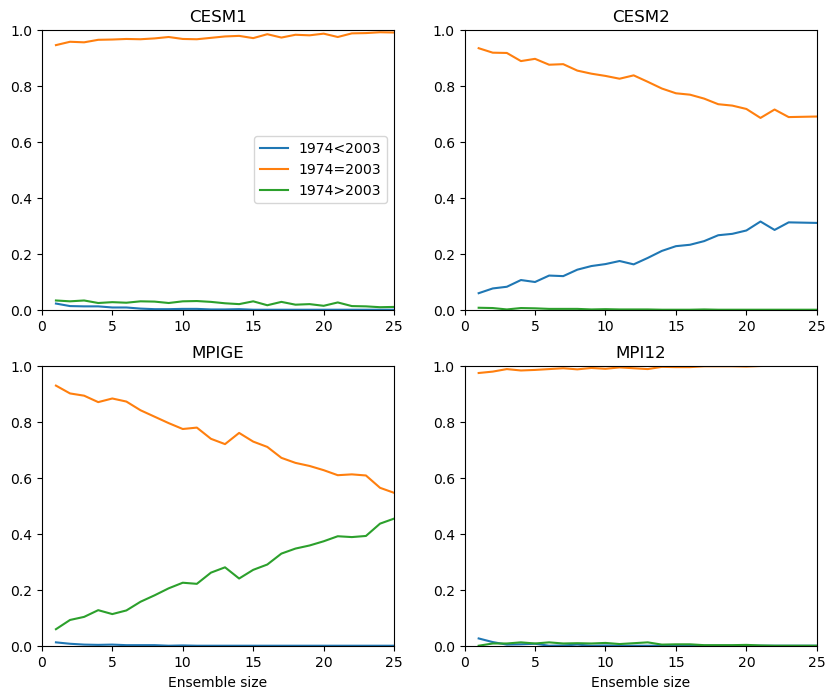

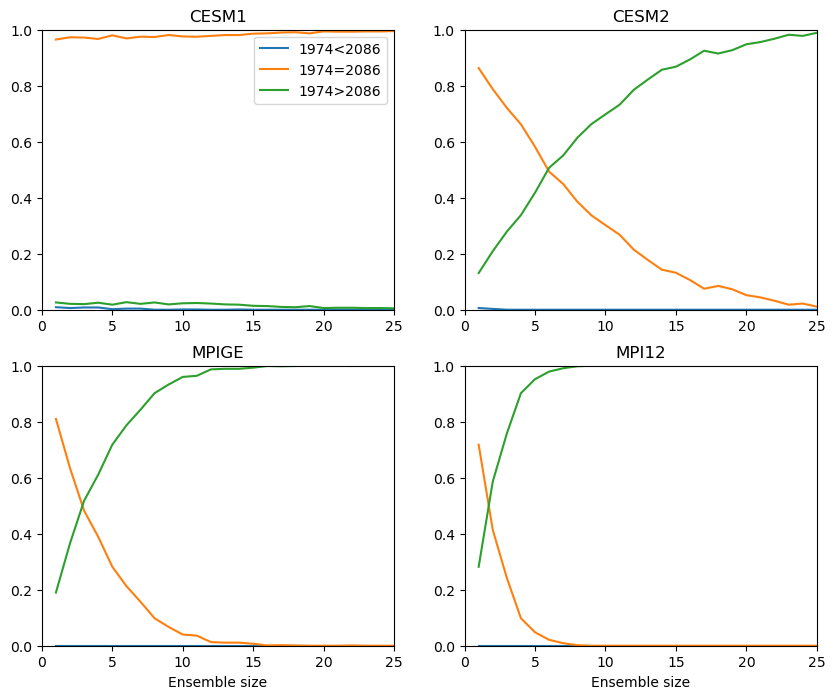

In [42]:
yys=['2003','2086']
for yy in yys:
    plt.figure(figsize=[10,8])
    mdls=['cesm1','cesm2','mpige','mpi12']
    for i,mdl in enumerate(mdls):
        plt.subplot(221+i)
        f='../data/bootstrap/'+mdl+'_1974_'+yy+'_mine.csv'
        df=pd.read_csv(f,index_col='nEns')
        for x in df:
            (df[x]/1000).plot()
        if i==0:
            plt.legend(['1974<'+yy,'1974='+yy,'1974>'+yy])
        if i>1:
            plt.xlabel('Ensemble size')
        else:
            plt.xlabel('')
        plt.ylim([0,1])
        plt.xlim([0,25])
        plt.title(mdl.upper())
    plt.savefig('../figs/supp/mytest_1974_'+yy+'.png',dpi=300,bbox_inches='tight')

In [40]:
for i,mdl in enumerate(mdls):
    f='../data/bootstrap/'+mdl+'_1974_2003_wilc.csv'
    df=pd.read_csv(f,index_col='nEns')
    print(mdl,int(np.round(100*df['-1'][1]/1000)))

cesm1 45
cesm2 63
mpige 40
mpi12 44


0.536

In [34]:
df

,-1,0,1
nEns,,,
1,445,19,536
2,387,20,593
3,409,26,565
4,360,16,624
5,390,20,590
6,363,22,615
7,341,22,637
8,324,30,646
9,304,22,674


In [43]:
def mycomp(xs,ys,nens):
    rs=[subset(ds,nens) for i in range(2)]
    halfs=[0,1]
    X=np.vstack([np.hstack([x.sel(ens=r).stack({'ey':['ens','year']}) for x,r in zip(xs,rs)]),
                 np.hstack([half*x.sel(ens=r).stack({'ey':['ens','year']}) for x,r,half in zip(xs,rs,halfs)])]).T
    y=np.hstack([y.sel(ens=r).stack({'ey':['ens','year']}) for y,r in zip(ys,rs)])
    lm=sm.OLS(y,X).fit()
    gle=(lm.pvalues[1]<0.05)*(2*(lm.params[1]>0)-1)
    return gle

In [60]:
def mytest(ds,nens,nx):
    yys=[[1960,1989],[2073,2099]]#[1989,2018]]
    ixs=[get_ix(ds,yy[0],yy[1]) for yy in yys]
    xs=[detrend_dim(ds.SW_TROP.isel(year=ix),'year') for ix in ixs]
    ys=[detrend_dim(ds.NBP.isel(year=ix),'year') for ix in ixs]
    gle=[mycomp(xs,ys,nens) for i in range(nx)]
    return gle
    

In [61]:
mdls=['cesm1','cesm2','mpige','mpi12']
results={}
for mdl in mdls:
    f='../data/globann/'+mdl+'.globann.nc'
    ds=xr.open_dataset(f)
    with joblib.parallel_config(backend="dask"):
        results[mdl] = Parallel(verbose=1)(delayed(mytest)(ds,nens,1000) for nens in range(1,26))

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:   17.3s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   37.1s finished
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:    9.7s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   16.2s finished
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:    9.0s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:    8.0s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   13.9s finished


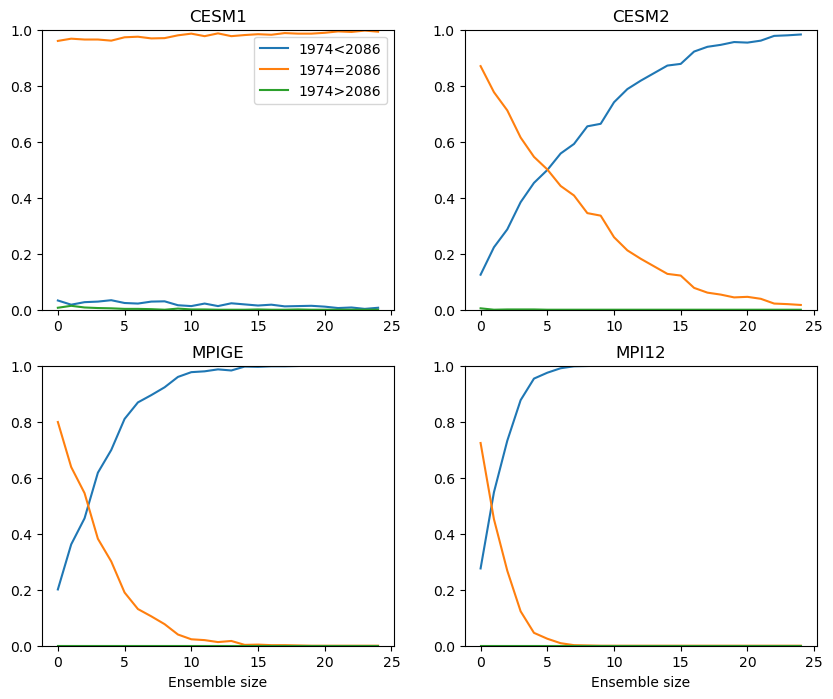

In [62]:
plt.figure(figsize=[10,8])
for i,mdl in enumerate(mdls):
    plt.subplot(221+i)
    for gle in [-1,0,1]:
        plt.plot([np.sum(np.array(r)==gle)/1000 for r in results[mdl]],label=gle)
    if i==0:
        plt.legend(['1974<2086','1974=2086','1974>2086'])
    if i>1:
        plt.xlabel('Ensemble size')
    plt.ylim([0,1])
    plt.title(mdl.upper())
plt.savefig('../figs/supp/mytest_1974_2086.png',dpi=300,bbox_inches='tight')

(array([  7.,   0.,   0.,   0.,   0., 929.,   0.,   0.,   0.,  64.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

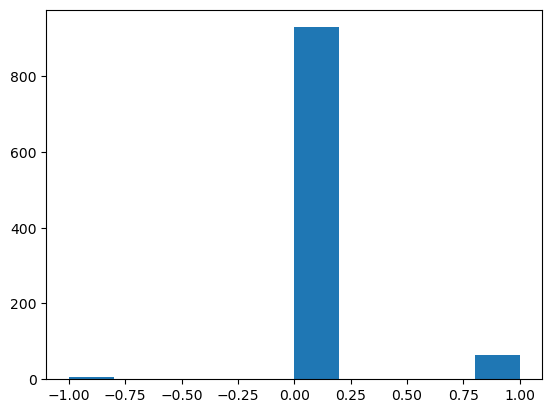

In [52]:
plt.hist(gle)

In [33]:
mdl='cesm2'

ds=xr.open_dataset(f)



In [34]:
ixs=
ds

<xarray.Dataset>
Dimensions:    (year: 181, ens: 100)
Coordinates:
  * year       (year) int64 1920 1921 1922 1923 1924 ... 2097 2098 2099 2100
  * ens        (ens) <U18 'cmip6.LE2-1001.001' ... 'smbb.LE2-1301.020'
    z_t        float32 ...
Data variables: (12/13)
    NBP        (ens, year) float64 ...
    NBP_TROP   (ens, year) float64 ...
    TSA        (ens, year) float64 ...
    TSA_TROP   (ens, year) float64 ...
    RAIN       (ens, year) float64 ...
    RAIN_TROP  (ens, year) float64 ...
    ...         ...
    SNOW_TROP  (ens, year) float64 ...
    SW         (ens, year) float64 ...
    SW_TROP    (ens, year) float64 ...
    PREC       (ens, year) float64 ...
    PREC_TROP  (ens, year) float64 ...
    NINO34     (ens, year) float64 ...

In [4]:
def get_gle(xs,ys,nboot,nx):
    gle=np.zeros(nboot)+np.nan
    nens=len(xs[0].ens)
    for i in range(nboot):    
        
        rs=[np.random.randint(nens,size=nx) for i in range(2)]
        halfs=[0,1]
        X=np.vstack([np.hstack([x.isel(ens=r).stack({'ey':['ens','year']}) for x,r in zip(xs,rs)]),
                     np.hstack([half*x.isel(ens=r).stack({'ey':['ens','year']}) for x,r,half in zip(xs,rs,halfs)])]).T
        y=np.hstack([y.isel(ens=r).stack({'ey':['ens','year']}) for y,r in zip(ys,rs)])
        lm=sm.OLS(y,X).fit()
        gle[i]=(lm.pvalues[1]<0.05)*(2*(lm.params[1]>0)-1)
    return gle

In [5]:
def get_ixs(ds):
    yr0=1973
    yr1=1977
    ny=0
    i=0
    ix0s=[]
    while ny<50:
        i+=1
        ix0=get_ix(ds,yr0,yr1)
        if ix0.sum()>ny:
            ny=ix0.sum()
            ix0s.append(ix0)
        if i%2>0:
            yr0-=1
        else:
            yr1+=1
    return ix0s




In [23]:
def compmems(ix0,nmem):
    yr0=2074
    ny=ix0.sum()
    ix1=get_ix(ds,yr0,yr0+ny-1)
    
    
    ixs=[ix0,ix1]
    xs=[detrend_dim(ds.SW_TROP.isel(year=ix),'year') for ix in ixs]
    ys=[detrend_dim(ds.NBP.isel(year=ix),'year') for ix in ixs]
    gle=get_gle(xs,ys,1000,nmem)
    return gle
    

In [24]:
mem10={}
mdls=['cesm1','cesm2','mpige','mpi12']
for mdl in mdls:
    f='../data/globann/'+mdl+'.globann.nc'
    ds=xr.open_dataset(f)
    ix0s=get_ixs(ds)
    with joblib.parallel_config(backend="dask"):
        mem10[mdl] = Parallel(verbose=1)(delayed(compmems)(ix,10) for ix in ix0s)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 50 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  46 | elapsed:    8.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 50 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  46 | elapsed:    8.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 50 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  46 | elapsed:    8.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 50 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  46 | elapsed:    8.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    8.8s finished


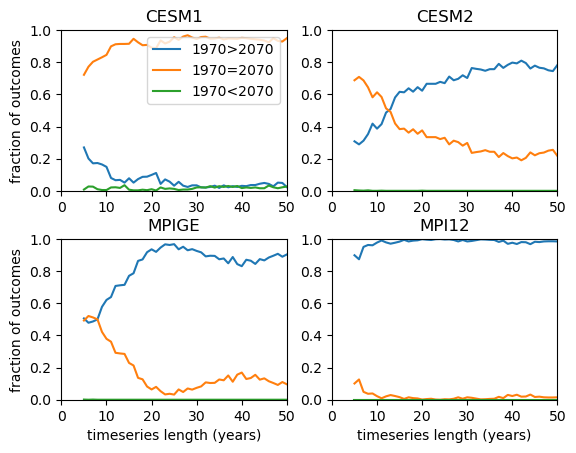

In [25]:
ny=[ix.sum() for ix in ix0s]
for i,mdl in enumerate(mdls):
    plt.subplot(221+i)
    for m in [-1,0,1]:
        x=[(gle==m).sum()/1000 for gle in mem10[mdl]]
        plt.plot(ny,x)
    plt.ylim([0,1])
    plt.xlim([0,50])
    plt.title(mdl.upper())
    if i==0:
        plt.legend(['1970>2070','1970=2070','1970<2070'],loc=1)
    if i>1:
        plt.xlabel('timeseries length (years)')
    if i%2==0:
        plt.ylabel('fraction of outcomes')

plt.subplots_adjust(hspace=0.3)
plt.savefig('../figs/aug/test10mems.png',dpi=300,bbox_inches='tight')

In [6]:
yr0=2074
for ix0 in ix0s[::4]:
    ny=ix0.sum()
    
    ix1=get_ix(ds,yr0,yr0+ny-1)
    ixs=[ix0,ix1]
    xs=[detrend_dim(ds.SW_TROP.isel(year=ix),'year') for ix in ixs]
    ys=[detrend_dim(ds.NBP.isel(year=ix),'year') for ix in ixs]
    
    gle=get_gle(xs,ys,500,5)
    
    print(ny.values,(gle==-1).sum())

5 99
9 118
13 144
17 181
21 199
25 204
29 222
33 240
37 241
41 257
45 266
49 249


In [28]:
ix0=get_ix(ds,1947,2002)
ny=ix0.sum()

ix1=get_ix(ds,yr0,yr0+ny-1)
ixs=[ix0,ix1]
xs=[detrend_dim(ds.SW_TROP.isel(year=ix),'year') for ix in ixs]
ys=[detrend_dim(ds.NBP.isel(year=ix),'year') for ix in ixs]

gle=get_gle(xs,ys,500,5)
(gle==-1).sum()

312

(array([320.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 180.]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ]),
 <BarContainer object of 10 artists>)

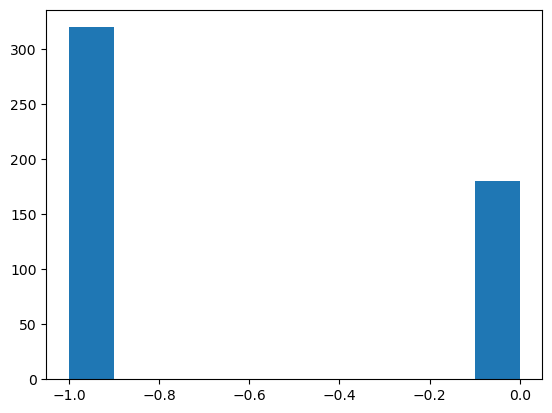

In [19]:
plt.hist(gle)

In [5]:
mdls=['cesm1','cesm2','mpige','mpi12']
results={}
for mdl in mdls:
    print(mdl)
    f='../data/globann/'+mdl+'.globann.nc'
    ds=xr.open_dataset(f)
    ixs=[get_ix(ds,1960,1989),get_ix(ds,2073,2099)]
    xs=[detrend_dim(ds.SW_TROP.isel(year=ix),'year') for ix in ixs]
    ys=[detrend_dim(ds.NBP.isel(year=ix),'year') for ix in ixs]
    with joblib.parallel_config(backend="dask"):
        results[mdl] = Parallel(verbose=1)(delayed(get_gle)(xs,ys,1000,i) for i in range(1,20))
    

In [3]:
client=get_cluster()

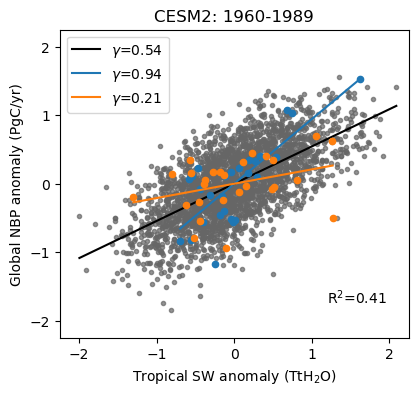

In [12]:
cf=24*60*60*365
ix=get_ix(ds,1960,1989)
x=latrop.sum()*1e-9*detrend_dim(ds.SW_TROP.isel(year=ix),'year')
y=la.sum()*1e-9*detrend_dim(cf*ds.NBP.isel(year=ix),'year')
m,b,r,p,err=stats.linregress(x.values.ravel(),y.values.ravel())
mvals=[stats.linregress(x,y)[0] for x,y in zip(x,y)]


plt.figure(figsize=[4.5,4])
plt.plot(x,y,'.',color=0.4*np.ones(3),alpha=0.7)
xx=np.array([x.min(),x.max()])
plt.xlim([-2.25,2.25])
plt.ylim([-2.25,2.25])
plt.text(1.2,-1.75,'R$^2$='+str(np.round(r**2,2)))
plt.plot(xx,m*xx+b,'k-',
         label='$\gamma$='+str(np.round(m,2)));

plt.xticks(range(-2,3))
plt.yticks(range(-2,3))

i=-1
for ee in [np.argmax(mvals),np.argmin(mvals)]:
    i+=1
    plt.plot(x.isel(ens=ee),y.isel(ens=ee),'C{}.'.format(i),ms=9);
    xx=np.array([x.isel(ens=ee).min(),x.isel(ens=ee).max()])
    plt.plot(xx,mvals[ee]*xx,'C{}-'.format(i),
             label='$\gamma$='+str(np.round(mvals[ee],2)));

plt.xlabel('Tropical SW anomaly (TtH$_2$O)')
plt.ylabel('Global NBP anomaly (PgC/yr)')
plt.title('CESM2: 1960-1989')
plt.legend(loc=2);
#plt.savefig('../figs/june/cesm2_scatter_1960.png',dpi=300)

In [4]:
import joblib
from joblib import Parallel, delayed

In [5]:
client.cluster

PBSCluster(ae64c33c, 'tcp://128.117.208.103:44163', workers=16, threads=16, memory=148.96 GiB)

In [6]:
def get_gle(xs,ys,nboot,nx):
    gle=np.zeros(nboot)+np.nan
    nens=len(xs[0].ens)
    for i in range(nboot):    
        
        rs=[np.random.randint(nens,size=nx) for i in range(2)]
        halfs=[0,1]
        X=np.vstack([np.hstack([x.isel(ens=r).stack({'ey':['ens','year']}) for x,r in zip(xs,rs)]),
                     np.hstack([half*x.isel(ens=r).stack({'ey':['ens','year']}) for x,r,half in zip(xs,rs,halfs)])]).T
        y=np.hstack([y.isel(ens=r).stack({'ey':['ens','year']}) for y,r in zip(ys,rs)])
        lm=sm.OLS(y,X).fit()
        gle[i]=(lm.pvalues[1]<0.05)*(2*(lm.params[1]>0)-1)
    return gle

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    7.5s finished


In [7]:
mdls=['cesm1','cesm2','mpige','mpi12']
results={}
for mdl in mdls:
    print(mdl)
    f='../data/globann/'+mdl+'.globann.nc'
    ds=xr.open_dataset(f)
    ixs=[get_ix(ds,1960,1989),get_ix(ds,2073,2099)]
    xs=[detrend_dim(ds.SW_TROP.isel(year=ix),'year') for ix in ixs]
    ys=[detrend_dim(ds.NBP.isel(year=ix),'year') for ix in ixs]
    with joblib.parallel_config(backend="dask"):
        results[mdl] = Parallel(verbose=1)(delayed(get_gle)(xs,ys,1000,i) for i in range(1,20))
    

cesm1


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   37.2s finished
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 30 concurrent workers.


cesm2


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 30 concurrent workers.


mpige


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   16.8s finished


mpi12


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   15.7s finished


In [52]:
mdl='cesm2'
la=xr.open_dataset('mask_grnlnd_antarc.nc').landarea
latrop=la.where(abs(la.lat)<24)
f='../data/globann/'+mdl+'.globann.nc'
ds=xr.open_dataset(f)
cf=24*60*60*365
ix=get_ix(ds,1960,1989)
x=latrop.sum()*1e-9*detrend_dim(ds.SW_TROP.isel(year=ix),'year')
y=la.sum()*1e-9*detrend_dim(cf*ds.NBP.isel(year=ix),'year')
m,b,r,p,err=stats.linregress(x.values.ravel(),y.values.ravel())
mvals=[stats.linregress(x,y)[0] for x,y in zip(x,y)]

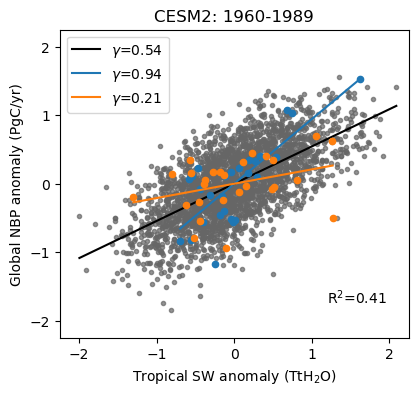

In [53]:
plt.figure(figsize=[4.5,4])





i=-1
for ee in [np.argmax(mvals),np.argmin(mvals)]:
    i+=1
    plt.plot(x.isel(ens=ee),y.isel(ens=ee),'C{}.'.format(i),ms=9);
    xx=np.array([x.isel(ens=ee).min(),x.isel(ens=ee).max()])
    plt.plot(xx,mvals[ee]*xx,'C{}-'.format(i),
             label='$\gamma$='+str(np.round(mvals[ee],2)));


#plt.savefig('../figs/june/cesm2_scatter_1960.png',dpi=300)

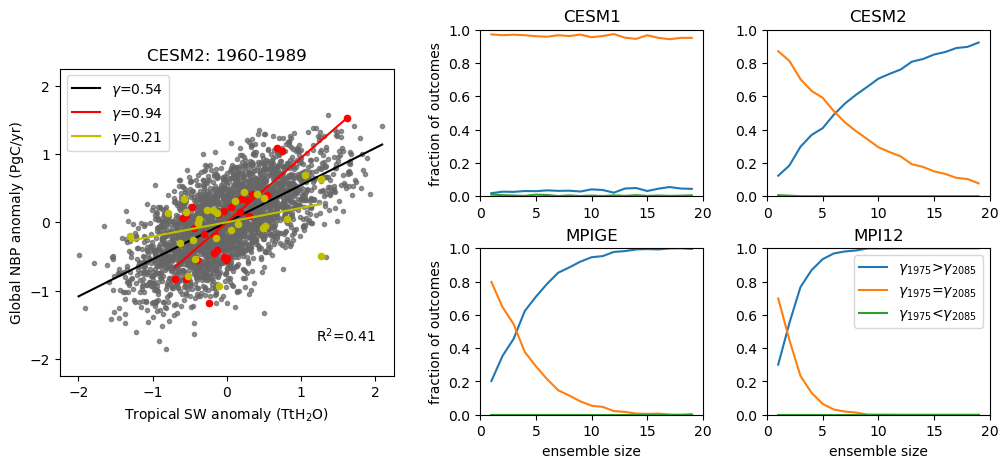

In [65]:
fig,axs=plt.subplot_mosaic('TUBVC;AUBVC;AWWWW;AYDZE;XYDZE',figsize=[12,5],
                            gridspec_kw={'width_ratios': [1.5,0.1,1,0,1],'height_ratios': [0.2,1, 0.2,1,0.2]})
for s in 'TUVWXYZ':
    axs[s].axis('off')

ax=axs['A']
ax.plot(x,y,'.',color=0.4*np.ones(3),alpha=0.7)
xx=np.array([x.min(),x.max()])
ax.set_xlim([-2.25,2.25])
ax.set_ylim([-2.25,2.25])
ax.text(1.2,-1.75,'R$^2$='+str(np.round(r**2,2)))
ax.plot(xx,m*xx+b,'k-',
         label='$\gamma$='+str(np.round(m,2)));

cs=['r','y']
for ee,c in zip([np.argmax(mvals),np.argmin(mvals)],cs):
    ax.plot(x.isel(ens=ee),y.isel(ens=ee),c+'.',ms=9);
    xx=np.array([x.isel(ens=ee).min(),x.isel(ens=ee).max()])
    ax.plot(xx,mvals[ee]*xx,c+'-',
             label='$\gamma$='+str(np.round(mvals[ee],2)));

ax.set_xticks(range(-2,3))
ax.set_yticks(range(-2,3))
ax.set_title('CESM2: 1960-1989')
ax.set_xlabel('Tropical SW anomaly (TtH$_2$O)')
ax.set_ylabel('Global NBP anomaly (PgC/yr)')
ax.legend(loc=2);



for mdl,s in zip(mdls,'BCDE'):
    for i,sgn in enumerate([-1,0,1]):
        axs[s].plot(range(1,20),[(r==sgn).sum()/1000 for r in results[mdl]],
                 label='$\gamma_{1975}$'+syms[i]+'$\gamma_{2085}$')
    if s in 'BD':
        axs[s].set_ylabel('fraction of outcomes')
    if s in 'DE':
        axs[s].set_xlabel('ensemble size')
    if s=='E':
        axs[s].legend()
    axs[s].set_ylim([0,1])
    axs[s].set_xlim([0,20])
    axs[s].set_title(mdl.upper())
    
plt.savefig('../figs/main/fig2.png',dpi=300,bbox_inches='tight')  

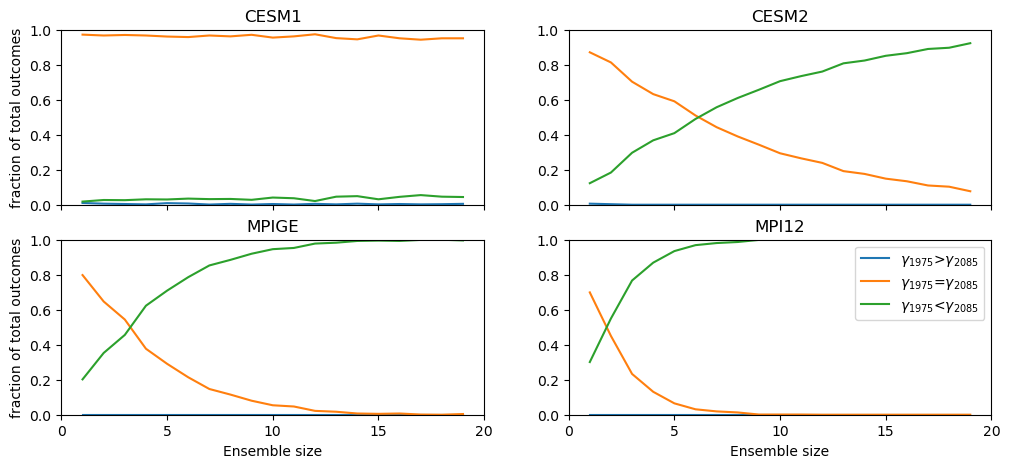

In [17]:
fig=plt.figure(figsize=[12,5])
for j,mdl in enumerate(mdls):
    plt.subplot(221+j)
    syms=['>','=','<']
    for i,sgn in enumerate([1,0,-1]):
        plt.plot(range(1,20),[(r==sgn).sum()/1000 for r in results[mdl]],
                 label='$\gamma_{1975}$'+syms[i]+'$\gamma_{2085}$')

    if (j%2)==0:
        plt.ylabel('fraction of total outcomes')
    if j==3:
        plt.legend()
    if j<2:
        plt.xticks(range(0,21,5),[])
    else:
        plt.xticks(range(0,21,5))
        plt.xlabel('Ensemble size')
    plt.xlim([0,20])
    plt.ylim([0,1])
    plt.title(mdl.upper())


In [1]:
5+5

10

In [143]:
import numpy as np
from sklearn.decomposition import PCA

In [211]:
client=get_cluster()

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34481 instead
  warnings.warn(


In [212]:
d='/glade/derecho/scratch/djk2120/postp/twsnbp/cesm2/'
files=sorted(glob.glob(d+'*'))

In [214]:
ds=xr.open_mfdataset(files,combine='nested',concat_dim='ens',parallel=True)

In [218]:
ixy=get_ix(ds,1960,1989)
ixt=(latrop>0).stack({'gc':['lat','lon']})
swt=detrend_dim(ds.SW.isel(year=ixy),'year').stack({'gc':['lat','lon']}).isel(gc=ixt).stack({'ey':['ens','year']}).T

In [222]:
nbp=detrend_dim(gmean(ds.NBP.isel(year=ixy),la),'year').stack({'ey':['ens','year']})

In [253]:
pca = PCA(n_components=20)
pca.fit(swt)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.21127279 0.05532744 0.04929072 0.04049511 0.03813794 0.02272615
 0.01961999 0.01893494 0.0186434  0.0165322  0.01533564 0.01477441
 0.01317998 0.01244188 0.01118256 0.01046968 0.00924854 0.00911458
 0.00827995 0.00789175]
[118203.06759684  60489.11614779  57093.87630071  51749.75136785
  50221.0236669   38767.68695714  36021.04716336  35386.61071078
  35113.1268857   33065.28457592  31846.22509696  31258.05832608
  29523.26041673  28684.67319463  27194.27763276  26313.20022244
  24731.10908335  24551.34012415  23400.27233251  22845.12858253]


In [254]:
evals=pca.fit_transform(swt)

In [263]:
sm.OLS(nbp.values,evals[:,:5]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.457
Model:                            OLS   Adj. R-squared (uncentered):              0.456
Method:                 Least Squares   F-statistic:                              454.3
Date:                Wed, 10 Jul 2024   Prob (F-statistic):                        0.00
Time:                        12:57:35   Log-Likelihood:                          39825.
No. Observations:                2700   AIC:                                 -7.964e+04
Df Residuals:                    2695   BIC:                                 -7.961e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2.413e-11   8.05e-13     29.983      0.000    2.26e-11    2.57e-11
x2          3.632e-11   1.57e-12     23.093      0.000    3.32e-11    3.94e-11
x3          -3.57e-11   1.67e-12    -21.424      0.000    -3.9e-11   -3.24e-11
x4          -5.11e-12   1.84e-12     -2.780      0.005   -8.72e-12   -1.51e-12
x5          3.657e-11   1.89e-12     19.304      0.000    3.29e-11    4.03e-11
==============================================================================
Omnibus:                        5.052   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.080   Jarque-Bera (JB):                4.708
Skew:                          -0.061   Prob(JB):                       0.0950
Kurtosis:                       2.836   Cond. No.                         2.35
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [267]:
sw=detrend_dim(gmean(ds.SW.isel(year=ix),latrop),'year').stack({'ey':['ens','year']})
sw

<xarray.DataArray (ey: 2700)>
array([-27.77044938,  13.60748196,   2.96297612, ...,  -0.95156225,
        -7.26506414,  -0.24355823])
Coordinates:
    z_t      float32 500.0
  * ey       (ey) object MultiIndex
  * ens      (ey) int64 0 0 0 0 0 0 0 0 0 0 0 ... 99 99 99 99 99 99 99 99 99 99
  * year     (ey) int64 1960 1961 1964 1965 1966 ... 1985 1986 1987 1988 1989

(2700, 2)

In [281]:
X=np.vstack([sw,evals[:,2]]).T
sm.OLS(nbp.values,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.432
Model:                            OLS   Adj. R-squared (uncentered):              0.431
Method:                 Least Squares   F-statistic:                              1024.
Date:                Wed, 10 Jul 2024   Prob (F-statistic):                        0.00
Time:                        13:01:50   Log-Likelihood:                          39762.
No. Observations:                2700   AIC:                                 -7.952e+04
Df Residuals:                    2698   BIC:                                 -7.951e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          6.098e-09   1.52e-10     40.118      0.000     5.8e-09     6.4e-09
x2         -1.618e-11   1.77e-12     -9.126      0.000   -1.97e-11   -1.27e-11
==============================================================================
Omnibus:                        4.485   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.106   Jarque-Bera (JB):                4.482
Skew:                          -0.084   Prob(JB):                        0.106
Kurtosis:                       2.893   Cond. No.                         89.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [255]:
[np.corrcoef(e,nbp)[0,1] for e in evals.T]

[0.4254485708478173,
 0.3276814435804616,
 -0.30399959261448706,
 -0.03944647735039214,
 0.27391835037083045,
 0.06272764121383258,
 -0.08140465044293435,
 -0.006164764371303475,
 -0.04074159233581145,
 0.028077201529916218,
 0.14102308250873635,
 -0.02551550701029237,
 0.015433083122715666,
 0.003612918949611649,
 -0.030236635137397865,
 0.03118165393977125,
 0.038821843427281226,
 0.00627063769157442,
 0.01305028245391572,
 0.04919661308298046]

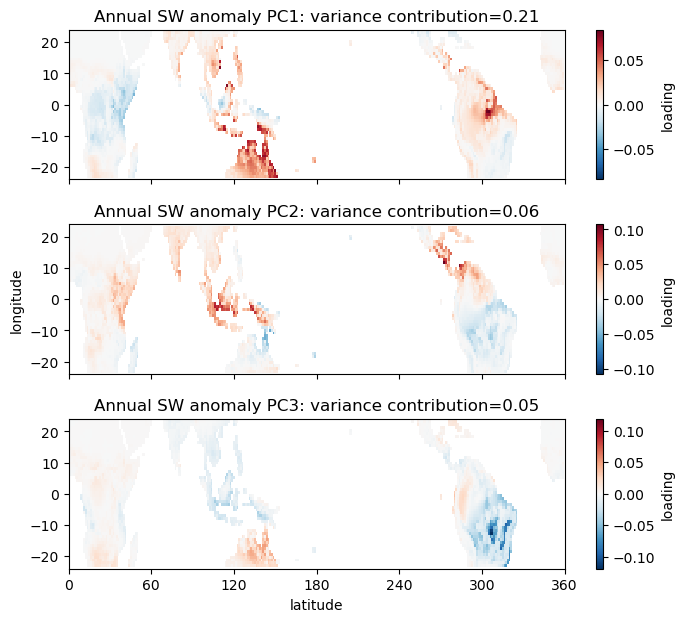

In [287]:
plt.figure(figsize=[8,7])
p=xr.DataArray(np.zeros(la.shape)+np.nan,coords=la.coords).stack({'gc':['lat','lon']})
for i in range(3):
    plt.subplot(311+i)
    p[ixt]=pca.components_[i]
    p.unstack().plot(cbar_kwargs={'label':'loading'})
    plt.ylim([-24,24])
    plt.xlabel('')
    plt.ylabel('')
    plt.xlim([0,360])
    r2=np.round(pca.explained_variance_ratio_[i],2)
    plt.title('Annual SW anomaly PC'+str(i+1)+': variance contribution='+str(r2))
    if i==1:
        plt.ylabel('longitude')
    if i==2:
        plt.xticks(range(0,361,60))
        plt.xlabel('latitude')
    else:
        plt.xticks(range(0,361,60),[])
        
plt.subplots_adjust(hspace=0.3)
plt.savefig('../figs/june/SW_pcas_CESM2_1960.png',dpi=300,bbox_inches='tight')

(100, 27)

In [64]:
xs=[(latrop.sum()*1e-9*detrend_dim(ds.SW_TROP.isel(year=ix),'year')).values.ravel()]
y=ds.year.isel(year=ix)
for yy in y:
    xs.append(np.tile(y*(y==yy),[100,1]).ravel())

In [67]:
np.vstack(xs).shape

(28, 2700)

In [10]:
mems=['LE2'+m.split('LE2')[1] for m in ds.ens.values]

In [106]:
def get_cesm2_m(v,month=0):
    d='/glade/campaign/cgd/cesm/CESM2-LE/timeseries/lnd/proc/tseries/month_1/{}/'.format(v)
    files=[sorted(glob.glob(d+'*'+mem+'*.h0.*.nc'))[11:14] for mem in mems]


    def pp(ds):
        
        ds=fix_time(ds)
        ix=(ds['time.year']>=1960)&(ds['time.year']<1990)
        x=ds[v].isel(time=ix)
        if month>0:
            ixm=x['time.month']==month
            x=x.isel(time=ixm)
            x['year']=x['time.year']
            x=x.swap_dims({'time':'year'})
        else:
            x=amean(x)
        return x
    
    ds=xr.open_mfdataset(files,combine='nested',concat_dim=['ens','year'],
                         preprocess=pp,parallel=True)
    return ds

In [89]:
x=get_cesm2_m('FSDS',0)

In [107]:
x=get_cesm2_m('SNOWDP',5)

In [111]:
sdp=gmean(x,la.where(la.lat>60))

In [91]:
fsds=gmean(x,la)

In [93]:
ix=get_ix(fsds,1960,1989)

In [113]:
ix=get_ix(sdp,1960,1989)
x1=detrend_dim(sdp.isel(year=ix),'year').values.ravel()

In [101]:
ix=get_ix(fsds,1960,1989)
x1=detrend_dim(fsds.isel(year=ix),'year').values.ravel()

In [134]:
ixaus=(la.lat<-10)&(la.lon>100)&(la.lon<160)
aus=la.where(ixaus)

In [124]:
d='/glade/derecho/scratch/djk2120/postp/twsnbp/cesm2/'
files=sorted(glob.glob(d+'*.nc'))
tmp=xr.open_mfdataset(files,combine='nested',concat_dim='ens',parallel=True)

In [139]:
ixnot=(abs(la.lat)<24)&(~ixaus)
lanot=la.where(ixnot)

In [140]:
ix=get_ix(tmp,1960,1989)
swaus=detrend_dim(gmean(tmp.SW.isel(year=ix),aus),'year')
swnot=detrend_dim(gmean(tmp.SW.isel(year=ix),lanot),'year')

In [141]:
ix=get_ix(ds,1960,1989)
x0=(lanot.sum()*1e-9*swnot).values.ravel()
x1=(aus.sum()*1e-9*swaus).values.ravel()
y=(la.sum()*1e-9*detrend_dim(cf*ds.NBP.isel(year=ix),'year')).values.ravel()
lm=sm.OLS(y,np.vstack([x0,x1]).T).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.444
Model:                            OLS   Adj. R-squared (uncentered):              0.444
Method:                 Least Squares   F-statistic:                              1078.
Date:                Wed, 10 Jul 2024   Prob (F-statistic):                        0.00
Time:                        11:25:21   Log-Likelihood:                         -1368.5
No. Observations:                2700   AIC:                                      2741.
Df Residuals:                    2698   BIC:                                      2753.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6711      0.016     40.685      0.000       0.639       0.703
x2             0.1264      0.016      8.069      0.000       0.096       0.157
==============================================================================
Omnibus:                        3.247   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.197   Jarque-Bera (JB):                3.241
Skew:                          -0.065   Prob(JB):                        0.198
Kurtosis:                       2.892   Cond. No.                         1.40
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
yrs=['1960','1989','2073']
files=[sorted(glob.glob('../data/slopes/mpi12/*'+yr+'*.nc')) for yr in yrs]
ds=xr.open_mfdataset(files,combine='nested',concat_dim=['year','ens'])

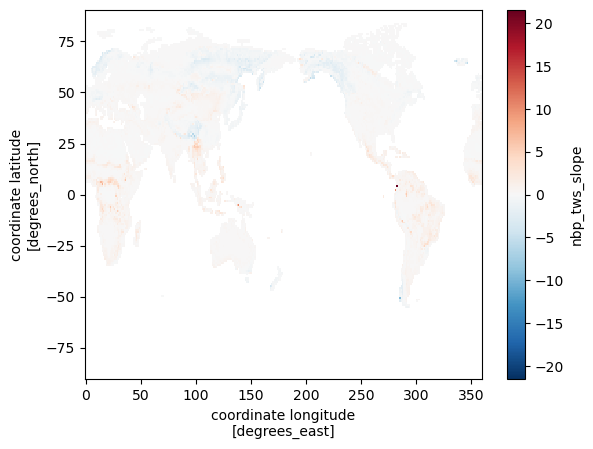

In [30]:
ds.nbp_tws_slope.isel(year=0).mean(dim='ens').plot();

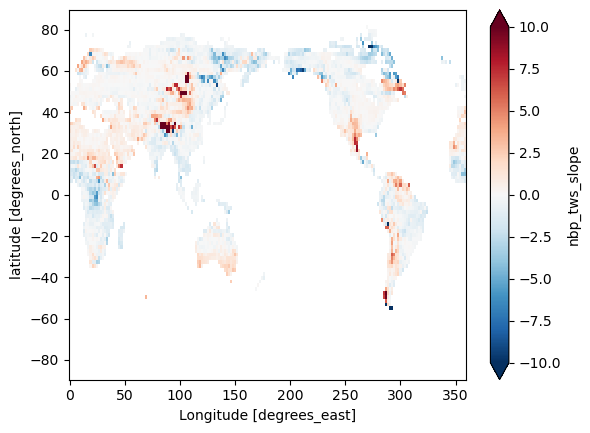

In [37]:
dx=(ds.nbp_tws_slope.isel(year=2).mean(dim='ens')-
    ds.nbp_tws_slope.isel(year=1).mean(dim='ens'))
dx.plot(vmin=-10,vmax=10,cmap='RdBu_r');

In [61]:
d='/glade/derecho/scratch/djk2120/postp/twsnbp/mpi12/'
f=d+'mpi12.r002.gridded.nc'


In [79]:
import xarray as xr
import numpy as np
from scipy import stats
from utils import *
import sys

f=sys.argv[1]

if 'mpi' in f:
    la=xr.open_dataset('mpi_mask_grnlnd_antarc.nc').landarea
    v1='mrso'
    v2='nbp'
else:
    la=xr.open_dataset('mask_grnlnd_antarc.nc').landarea
    v1='SW'
    v2='NBP'

#load data
ds=xr.open_dataset(f)

ixys={'1960':get_ix(ds,1960,1989),
      '1989':get_ix(ds,1989,2018),
      '2073':get_ix(ds,2073,2099)}

for yr in ixys:
    print(yr)
    #detrend
    cf=24*60*60*365
    ixy=ixys[yr]
    x=detrend_dim(ds[v1].sel(year=ixy),'year')
    y=cf*detrend_dim(ds[v2].sel(year=ixy),'year')
    
    #calc slopes (only where relevant)
    ix=(x.std(dim='year')>0)&(la>0)
    ixg=ix.stack({'gc':['lat','lon']})
    xg=x.stack({'gc':['lat','lon']})
    yg=y.stack({'gc':['lat','lon']})
    mgs=[stats.linregress(x,y)[0] for x,y in zip(xg.isel(gc=ixg).T,yg.isel(gc=ixg).T)]
    
    #convert to DataArray with lat/lon coords
    mg=xr.DataArray(np.zeros(la.shape)+np.nan, coords=la.coords).stack({'gc':['lat','lon']})
    mg[ixg]=mgs
    m=mg.unstack()
    
    #write to file
    dout='../data/slopes/'
    fout=dout+f.split('/')[-2]+'/'+f.split('/')[-1].split('gridded')[0]+yr+'.slopes.nc'
    m.to_netcdf(fout)

1960
1989
2073


In [71]:
yr='1960'

In [76]:
fout

'../data/mpi12/mpi12.r002.1960.slopes.nc'

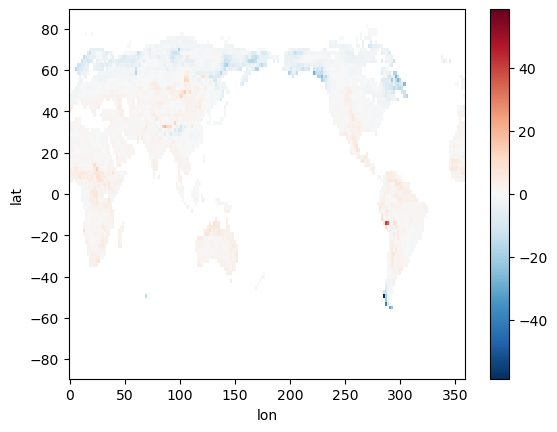

In [63]:
m.plot()

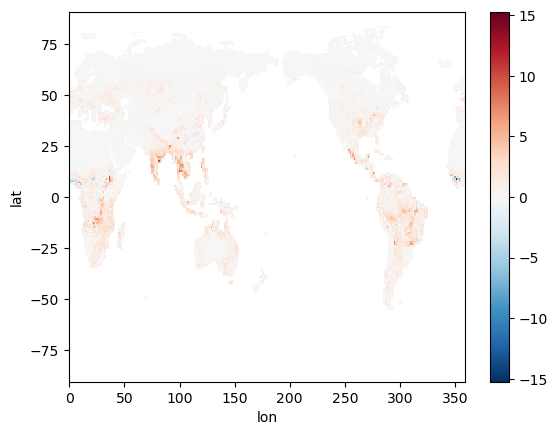

In [49]:
m.plot()

In [3]:
ds=xr.open_dataset('../postp/cesm2.gridann.1976.nc')

In [4]:
ix=(ds.TWS.var(dim='year').min(dim='ens')>0).compute()
la=ix*xr.open_dataset('mask_grnlnd_antarc.nc').landarea
nx=(la>0).sum().values
ix=la>0

In [5]:
nens=len(ds.ens)
mgs=[];m0s=[];m1s=[];m2s=[]
for ee in range(nens):
    if ee%5==0:
        print(ee)
    xa=detrend_dim(1e-9*(la*ds.TWS.isel(ens=ee)).sum(dim=['lat','lon']),'year')
    ya=detrend_dim(1e-9*(24*60*60*365*la*ds.NBP.isel(ens=ee)).sum(dim=['lat','lon']),'year')
    m,b,r,p,err=stats.linregress(xa,ya)
    mgs.append(m)

    twsa=detrend_dim(la*ds.TWS.isel(ens=ee),'year').values[ix,:]
    nbpa=detrend_dim(24*60*60*365*la*ds.NBP.isel(ens=ee),'year').values[ix,:]

    mvals=np.array([stats.linregress(x,y)[0] for x,y in zip(twsa,nbpa)])

    wts=(la/la.sum()).values[ix]
    m0=(wts*mvals).sum()
    x=twsa.var(axis=1)
    wts=x/x.sum()
    m1=(wts*mvals).sum()
    covxx=np.cov(twsa)
    m2=(covxx*mvals).sum()/covxx.sum()

    m0s.append(m0)
    m1s.append(m1)
    m2s.append(m2)


0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


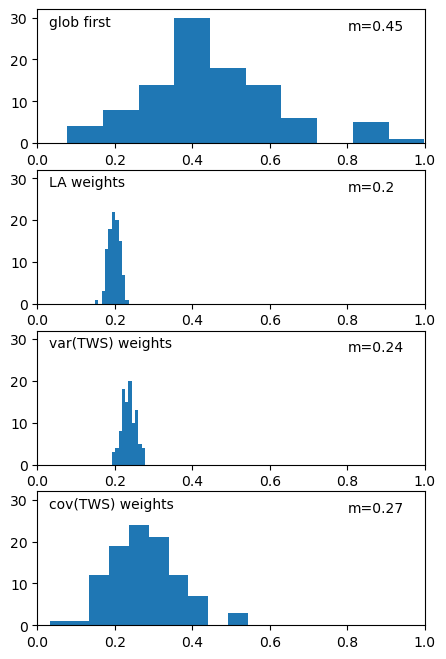

In [14]:
plt.figure(figsize=[5,8])
labs=['glob first','LA weights','var(TWS) weights','cov(TWS) weights']
for i,m in enumerate([mgs,m0s,m1s,m2s]):
    plt.subplot(4,1,i+1)
    plt.hist(m)
    plt.xlim([0,1])
    plt.ylim([0,32])
    plt.text(0.8,27,'m='+str(np.round(np.mean(m),2)))
    plt.text(0.03,28,labs[i])

In [54]:
las={}
las['cesm1']=xr.open_dataset('mask_grnlnd_antarc.nc').landarea
las['cesm2']=xr.open_dataset('mask_grnlnd_antarc.nc').landarea
las['mpige']=xr.open_dataset('mpi_mask_grnlnd_antarc.nc').landarea
las['mpi12']=xr.open_dataset('mpi_mask_grnlnd_antarc.nc').landarea

In [55]:
cfs={}
cfs['cesm1']=1
cfs['cesm2']=1
cfs['mpige']=1000
cfs['mpi12']=1000

In [65]:
mglobs={};mgrids={}
for mdl in ['cesm1','cesm2','mpige','mpi12']:
    print(mdl)
    ds=xr.open_dataset('../postp/'+mdl+'.gridann.1976.nc')

    ix=(ds.SW.var(dim='year').min(dim='ens')>0).compute()
    la=ix*las[mdl]
    nx=(la>0).sum().values
    ix=la>0

    m1=[]
    m2=[]
    for ee in range(len(ds.ens)):
        xa=detrend_dim(1e-9*(la*ds.SW.isel(ens=ee)).sum(dim=['lat','lon']),'year')
        ya=cfs[mdl]*detrend_dim(1e-9*(24*60*60*365*la*ds.NBP.isel(ens=ee)).sum(dim=['lat','lon']),'year')
        m,b,r,p,err=stats.linregress(xa,ya)
        m1.append(m)


        xa=detrend_dim(la*ds.SW.isel(ens=ee),'year').values[ix,:]
        ya=cfs[mdl]*detrend_dim(24*60*60*365*la*ds.NBP.isel(ens=ee),'year').values[ix,:]

        mvals=np.array([stats.linregress(x,y)[0] for x,y in zip(xa,ya)])
        varx=xa.var(axis=1)
        m2.append((varx*mvals).sum()/varx.sum())


    mglobs[mdl]=m1
    mgrids[mdl]=m2

cesm1
cesm2
mpige
mpi12


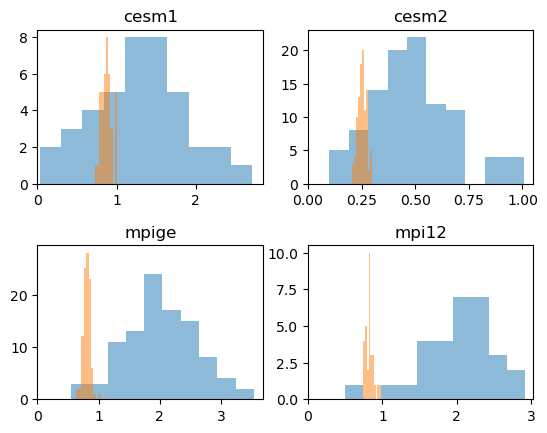

In [70]:
for i,mdl in enumerate(['cesm1','cesm2','mpige','mpi12']):
    plt.subplot(2,2,i+1)
    plt.hist(mglobs[mdl],alpha=0.5,)
    plt.hist(mgrids[mdl],alpha=0.5)
    plt.xlim(left=0)
    plt.title(mdl)
plt.subplots_adjust(hspace=0.4)

In [71]:
ds=xr.open_dataset('../postp/cesm2.gridann.1976.nc')

In [76]:
la=xr.open_dataset('mask_grnlnd_antarc.nc').landarea
ix=(ds.TWS.var(dim='year').min(dim='ens')>0).compute()
la=ix*la

In [81]:
ee=19
x1=detrend_dim(1e-9*(la*ds.TWS.isel(ens=ee)).sum(dim=['lat','lon']),'year')
x2=detrend_dim(1/la.sum()*(la*ds.TSA.isel(ens=ee)).sum(dim=['lat','lon']),'



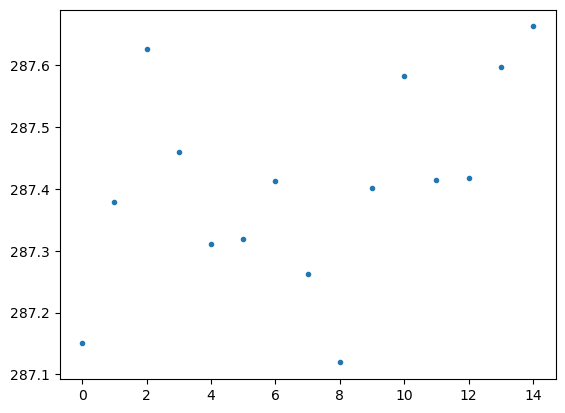

In [83]:
plt.plot(x2,'.')

In [37]:
lats=np.tile(ds.lat.values.reshape([-1,1]),[1,288])[ix]

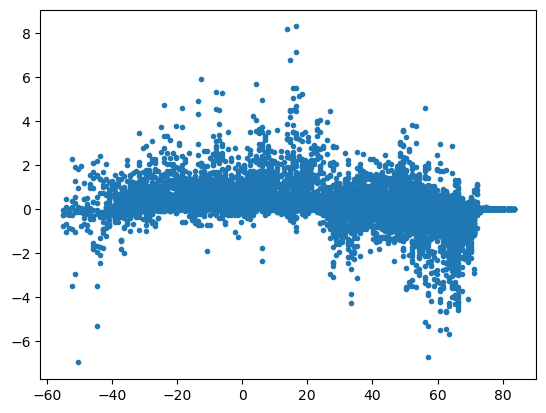

In [38]:
plt.plot(lats,mvals,'.')

In [130]:
m=np.zeros(100)
for ee in range(100):
    twsa=detrend_dim(la*ds.TWS.isel(ens=ee),'year').values[la>0,:]
    nbpa=detrend_dim(la*24*60*60*365*ds.NBP.isel(ens=ee),'year').values[la>0,:]
    covxx=np.cov(twsa)
    mvals=np.zeros([nx,1])+np.nan
    for i in range(nx):
        x=twsa[i,:]
        y=nbpa[i,:]
        mvals[i],b,r,p,err=stats.linregress(x,y)


    m[ee]=1/covxx.sum()*(covxx*mvals).sum()


In [134]:
xa=detrend_dim(1e-9*(la*ds.TWS).sum(dim=['lat','lon']),'year')
ya=detrend_dim(1e-9*24*60*60*365*(la*ds.NBP).sum(dim=['lat','lon']),'year')

In [139]:
mglob=np.zeros(100)
for ee in range(100):
    x=xa.sel(ens=ee)
    y=ya.sel(ens=ee)
    mglob[ee],b,r,p,err=stats.linregress(x,y)

In [142]:
stats.linregress(xa.values.ravel(),ya.values.ravel())

LinregressResult(slope=0.42186118610358736, intercept=9.286888407666875e-17, rvalue=0.5809385976354192, pvalue=4.1948914063228835e-136, stderr=0.01527143201032599, intercept_stderr=0.011168213448221408)

In [143]:
np.mean(m)

0.2723426062592149

(array([ 1.,  1., 12., 19., 24., 21., 12.,  7.,  0.,  3.]),
 array([0.03193086, 0.08297273, 0.1340146 , 0.18505648, 0.23609835,
        0.28714022, 0.33818209, 0.38922396, 0.44026584, 0.49130771,
        0.54234958]),
 <BarContainer object of 10 artists>)

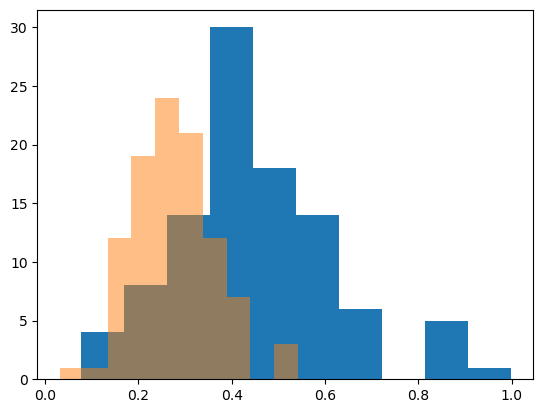

In [141]:
plt.hist(mglob)
plt.hist(m,alpha=0.5)

In [118]:
mvals.shape

(14233,)

In [110]:
1/covxx.sum()*(covxx*mvals).sum()

0.3013797760053688

In [ ]:
la.values

In [116]:
1/(la.values[la>0].sum())*(la.values[la>0]*mvals).sum()

0.2075709908763277

In [2]:
from utils import *

In [8]:
def preprocess(ds):
    dvs=[]
    yr0=ds['time.year'][0].values
    nt=len(ds.time)
    ds['time']=xr.cftime_range(str(yr0),periods=nt,freq='MS',calendar='noleap')
    if len(dvs)>0:
        ds=ds[dvs]
    return ds



In [17]:
f=lens_files('CESM2','TWS',yy=(1976,1990))[5]

In [20]:
ds=xr.open_mfdataset(f,combine='nested',concat_dim='time',preprocess=preprocess).sel(time=slice('1976','1990'))

In [55]:
tws=detrend_dim(amean(ds.TWS),'year').values

In [77]:
la=xr.open_dataset('mask_grnlnd_antarc.nc').landarea
ix=(la>0)&(tws.std(axis=0)>0)

In [79]:
nx=ix.sum().values

In [80]:

jvals=np.tile(range(288),[192,1])[ix]

In [82]:
g=np.zeros(la.shape)+np.nan
g[ix]=np.random.randint(5,size=nx)

In [85]:
def calcr2(tws,g,ng):
    return np.sum([np.corrcoef(tws[:,g==i].T).sum() for i in range(ng)])

In [114]:
r2=calcr2(tws,g,ng)
for i in range(1000):
    g,r2=testswap(tws,g,ng,r2)
    if i%50==0:
        print(i,int(np.round(r2)))

0 521250
50 529754
100 538955
150 548479
200 556306
250 565057
300 577552
350 588501
400 598297
450 606667
500 613793
550 625069
600 635144
650 650164
700 662123
750 672948
800 685022
850 697728
900 709715
950 720380


In [106]:
def testswap(tws,g,ng,r2):
    x1=np.random.randint(nx)
    i1,j1=ivals[x1],jvals[x1]
    g1=g[i1,j1]

    rvals=[]
    for gg in range(ng):
        if gg==g1:
            rvals.append(r2)
        else:
            g[i1,j1]=gg
            rvals.append(calcr2(tws,g,ng))
    g[i1,j1]=np.argmax(rvals)
    
    
    return g,np.max(rvals)

In [102]:
rvals=np.random.randint(10,size=5)
rvals,np.argmax(rvals)

(array([1, 9, 1, 0, 0]), 1)

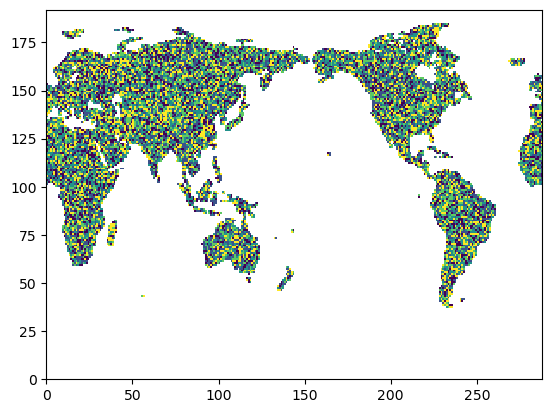

In [115]:
plt.pcolormesh(g)